# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
import logging.config
import random
import os
import time
import datetime
import math

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.transformer import _get_activation_fn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.ops import FeaturePyramidNetwork, DeformConv2d

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from RandAugment import RandAugment

import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch_optimizer as optim
import ttach as tta

from tqdm.notebook import tqdm
from pprint import pprint

import neptune.new as neptune

# Hyperparameter

In [2]:
neptune_run = neptune.init(
    project="djlee/dacon",
    api_token=os.environ["NEPTUNE_API_TOKEN"],
)

params = {
    "model_name": "tf_efficientnet_b0",
    "optimizer": "adam",
    "criterion": "ce",
    "scheduler": "cosineannealinglr",
    "num_class": 88,
    "epochs": 100,
    "batch": 16,
    "learning_rate": 1e-4,
    "weight_decay": 5e-2,
    "drop_out_rate": 0.4,
    "drop_path_rate": 0.15,
    "max_norm": 1,
    "num_workers": 4,
    "train_image_size": 224,
    "test_image_size": 224,
    "ib_start_epoch": 9999,
    "mixup": False,
    "mixup_end_epoch": -1,
    "mixup_alpha": 0.2,
    "seed": 42,
}

neptune_run["parameters"] = params

TRAIN_FILE = "data/train_df.csv"
TEST_FILE = "data/test_df.csv"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

SAVE_PATH = f"{params['model_name']}_{datetime.datetime.now().strftime('%H:%M:%S:%m')}"
os.makedirs(SAVE_PATH)

https://app.neptune.ai/djlee/dacon/e/DAC-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Logger

In [3]:
config = {
    "version": 1,
    "formatters": {
        "simple": {"format": "[%(asctime)s]\n%(message)s", "datefmt": "%Y-%m-%d %H:%M:%S"},
    },
    "handlers": {
        "console": {
            "class": "logging.StreamHandler",
            "formatter": "simple",
            "level": "INFO",
        },
        "file": {
            "class": "logging.FileHandler",
            "filename": f"{SAVE_PATH}/train.log",
            "formatter": "simple",
            "level": "INFO",
        },
    },
    "root": {"handlers": ["console", "file"], "level": "INFO"},
    "loggers": {"parent": {"level": "INFO"}, "parent.child": {"level": "DEBUG"},},
}

logging.config.dictConfig(config)
logger = logging.getLogger()
logger.info(params)

[2022-05-15 00:10:44]
{'model_name': 'tf_efficientnet_b0', 'optimizer': 'adam', 'criterion': 'ce', 'scheduler': 'cosineannealinglr', 'num_class': 88, 'epochs': 100, 'batch': 16, 'learning_rate': 0.0001, 'weight_decay': 0.05, 'drop_out_rate': 0.4, 'drop_path_rate': 0.15, 'max_norm': 1, 'num_workers': 4, 'train_image_size': 224, 'test_image_size': 224, 'ib_start_epoch': 9999, 'mixup': False, 'mixup_end_epoch': -1, 'mixup_alpha': 0.2, 'seed': 42}


# Fix Seed

In [4]:
random.seed(params["seed"])
np.random.seed(params["seed"])
os.environ["PYTHONHASHSEED"] = str(params["seed"])
torch.manual_seed(params["seed"])
torch.cuda.manual_seed(params["seed"])
torch.backends.cudnn.deterministic = False  # True 할 시 연산속도 감소. 마지막에 고정시킬 때 사용 권장.
torch.backends.cudnn.benchmark = True

# Class

## Mean, Std

In [5]:
class OnlineMeanStd:
    def __init__(self):
        pass

    def __call__(self, dataset, batch_size, method='strong'):
        """
        Calculate mean and std of a dataset in lazy mode (online)
        On mode strong, batch size will be discarded because we use batch_size=1 to minimize leaps.
        :param dataset: Dataset object corresponding to your dataset
        :param batch_size: higher size, more accurate approximation
        :param method: weak: fast but less accurate, strong: slow but very accurate - recommended = strong
        :return: A tuple of (mean, std) with size of (3,)
        """

        if method == 'weak':
            loader = DataLoader(dataset=dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                pin_memory=0)
            mean = 0.
            std = 0.
            nb_samples = 0.
            for data in loader:
                data = data[0]
                batch_samples = data.size(0)
                data = data.view(batch_samples, data.size(1), -1)
                mean += data.mean(2).sum(0)
                std += data.std(2).sum(0)
                nb_samples += batch_samples

            mean /= nb_samples
            std /= nb_samples

            return mean, std

        elif method == 'strong':
            loader = DataLoader(dataset=dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=1,
                                pin_memory=0)
            cnt = 0
            fst_moment = torch.empty(3)
            snd_moment = torch.empty(3)

            for data in loader:
                data = data
                b, c, h, w = data.shape
                nb_pixels = b * h * w
                sum_ = torch.sum(data, dim=[0, 2, 3])
                sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
                fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
                snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

                cnt += nb_pixels

            return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

## Dataset

In [6]:
class CustomDataset(Dataset):
    def __init__(self,
                 df,
                 mode,
                 mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
        self.mode = mode
        self.data = df
        if self.mode == "train":
            lbs = []
            for l in self.data["label"]:
                lbs.append(LABEL_ENCODER[l])
            self.labels = lbs
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
            name = self.data["file_name"][index]
            image = cv2.imread(f"data/{self.mode}/{name}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.mode == "train":
                label = LABEL_ENCODER[self.data["label"][index]]
                image = self.input_transform(image, LABEL_DECODER[label])["image"]
                return image, label
            image = self.input_transform(image)["image"]
            return image
        
    def input_transform(self, image, label=None):
        if self.mode == "train":
            if "metal_nut" in label:
                flip_p = 0
            else:
                flip_p = 0.5
            transform = A.Compose([
                            A.Resize(params["train_image_size"], params["train_image_size"], interpolation=cv2.INTER_AREA),
                            # A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1),
                            A.RandomRotate90(p=0.5),
                            A.HorizontalFlip(p=flip_p),
                            A.VerticalFlip(p=flip_p),
                            A.Affine(rotate=(-45, 45), translate_percent=(-0.1, 0.1), p=0.5),
                            A.Cutout(num_holes=16, p=0.5),
                            # A.GaussNoise(p=0.5),
                            # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                            A.Normalize(
                                mean = [0.4330, 0.4034, 0.3941],
                                std = [0.2602, 0.2572, 0.2535],
                            ),
                            ToTensorV2()
                        ])
            neptune_run["transforms"].log(transform)
            return transform(image=image)
        
        elif self.mode == "test":
            transform = A.Compose([
                            A.Resize(params["test_image_size"], params["test_image_size"], interpolation=cv2.INTER_AREA),
                            A.Normalize(
                                mean = [0.4183, 0.3931, 0.3866],
                                std = [0.2604, 0.2585, 0.2562]
                            ),
                            ToTensorV2(),
                        ])
            return transform(image=image)

## Sampler

In [7]:
class RandomCycleIter:
    
    def __init__ (self, data, test_mode=False):
        self.data_list = list(data)
        self.length = len(self.data_list)
        self.i = self.length - 1
        self.test_mode = test_mode
        
    def __iter__ (self):
        return self
    
    def __next__ (self):
        self.i += 1
        
        if self.i == self.length:
            self.i = 0
            if not self.test_mode:
                random.shuffle(self.data_list)
            
        return self.data_list[self.i]
    
def class_aware_sample_generator (cls_iter, data_iter_list, n, num_samples_cls=1, is_infinite=False):

    i = 0
    j = 0
    while i < n or is_infinite:
        
        if j >= num_samples_cls:
            j = 0
    
        if j == 0:
            temp_tuple = next(zip(*[data_iter_list[next(cls_iter)]]*num_samples_cls))
            yield temp_tuple[j]
        else:
            yield temp_tuple[j]
        
        i += 1
        j += 1

class ClassAwareSampler (Sampler):
    
    def __init__(self, data_source, num_samples_cls=1, is_infinite=False):
        num_classes = len(np.unique(data_source.labels))
        self.class_iter = RandomCycleIter(range(num_classes))
        cls_data_list = [list() for _ in range(num_classes)]
        for i, label in enumerate(data_source.labels):
            cls_data_list[label].append(i)
        self.data_iter_list = [RandomCycleIter(x) for x in cls_data_list]
        self.num_samples = max([len(x) for x in cls_data_list]) * len(cls_data_list)
        self.num_samples_cls = num_samples_cls

        self.is_infinite = is_infinite
        
    def __iter__ (self):
        return class_aware_sample_generator(self.class_iter, self.data_iter_list,
                                            self.num_samples, self.num_samples_cls, self.is_infinite)
    
    def __len__ (self):
        return self.num_samples
    
def get_sampler():
    return ClassAwareSampler

## Loss

### Cosine CrossEntropy Loss

In [8]:
class CosineCrossEntropyLoss(nn.Module):
    def __init__(self, xent=.1, reduction="mean", weight=None):
        super(CosineCrossEntropyLoss, self).__init__()
        self.xent = xent
        self.reduction = reduction
        self.weight = weight
        self.y = torch.Tensor([1]).cuda()
        
    def forward(self, input, target):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=self.reduction)
        cent_loss = F.cross_entropy(F.normalize(input), target, reduction=self.reduction, weight=self.weight)
        
        return cosine_loss + self.xent * cent_loss

### Cosine Focal Loss

In [9]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, xent=.1, reduction="mean", weight=None):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.xent = xent
        self.y = torch.Tensor([1]).cuda()
        self.reduction = reduction
        self.weight = weight

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=self.reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if self.reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

### Seesaw Loss

In [10]:
class SeesawLoss(torch.nn.Module):
    """
    Implementation of seesaw loss.
    Refers to `Seesaw Loss for Long-Tailed Instance Segmentation (CVPR 2021)
    <https://arxiv.org/abs/2008.10032>
    Args:
        num_classes (int): The number of classes.
                Default to 1000 for the ImageNet dataset.
        p (float): The ``p`` in the mitigation factor.
                Defaults to 0.8.
        q (float): The ``q`` in the compensation factor.
                Defaults to 2.0.
        eps (float): The min divisor to smooth the computation of compensation factor.
                Default to 1e-2.
    """

    def __init__(self, num_classes=params["num_class"],
                 p=0.8, q=1.0, eps=1e-2):
        super().__init__()
        self.num_classes = num_classes
        self.p = p
        self.q = q
        self.eps = eps

        # cumulative samples for each category
        self.register_buffer('accumulated',
                             torch.zeros(self.num_classes, dtype=torch.float))

    def forward(self, outputs, targets):
        # accumulate the samples for each category
        for unique in targets.unique():
            self.accumulated[unique] += (targets == unique.item()).sum()

        onehot_targets = F.one_hot(targets, self.num_classes)
        seesaw_weights = outputs.new_ones(onehot_targets.size())

        # mitigation factor
        if self.p > 0:
            matrix = self.accumulated[None, :].clamp(min=1) / self.accumulated[:, None].clamp(min=1)
            index = (matrix < 1.0).float()
            sample_weights = matrix.pow(self.p) * index + (1 - index)
            mitigation_factor = sample_weights[targets.long(), :]
            seesaw_weights = seesaw_weights * mitigation_factor

        # compensation factor
        if self.q > 0:
            scores = F.softmax(outputs.detach(), dim=1)
            self_scores = scores[torch.arange(0, len(scores)).to(scores.device).long(), targets.long()]
            score_matrix = scores / self_scores[:, None].clamp(min=self.eps)
            index = (score_matrix > 1.0).float()
            compensation_factor = score_matrix.pow(self.q) * index + (1 - index)
            seesaw_weights = seesaw_weights * compensation_factor

        outputs = outputs + (seesaw_weights.log() * (1 - onehot_targets))
        return F.cross_entropy(outputs, targets)

### Focal Loss

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, label_smoothing=0.1, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduce = reduce

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(label_smoothing=self.label_smoothing)(inputs, targets)
        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### CDB Loss

In [12]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

class CDB_loss(nn.Module):
  
    def __init__(self, class_difficulty, tau='dynamic', reduction='none'):
        
        super(CDB_loss, self).__init__()
        self.class_difficulty = class_difficulty
        if tau == 'dynamic':
            bias = (1 - np.min(class_difficulty))/(1 - np.max(class_difficulty) + 0.01)
            tau = sigmoid(bias)
        else:
            tau = float(tau) 
        self.weights = self.class_difficulty ** tau
        self.weights = self.weights / self.weights.sum() * len(self.weights)
        self.reduction = reduction
        self.loss = nn.CrossEntropyLoss(weight=torch.FloatTensor(self.weights), reduction=self.reduction).cuda()
        
    def forward(self, input, target):
        return self.loss(input, target)

### CB Loss

In [13]:
def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma, device):
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()
    labels_one_hot = labels_one_hot.to(device)

    weights = torch.tensor(weights).float()
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0],1).to(device)
    weights = weights* labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weights = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
    return cb_loss

### Equalized Focal Loss

In [14]:
def equalized_focal_loss(logits,
                         targets,
                         gamma_b=2,
                         scale_factor=8,
                         reduction="mean"):
    """ EFL loss"""
    ce_loss = F.cross_entropy(logits, targets, reduction="none", label_smoothing=0.1)
    outputs = F.cross_entropy(logits, targets, label_smoothing=0.1)
    log_pt = -ce_loss
    pt = torch.exp(log_pt)

    targets = targets.view(-1, 1)
    grad_i = torch.autograd.grad(outputs=-outputs, inputs=logits)[0]
    grad_i = grad_i.gather(1, targets)
    pos_grad_i = F.relu(grad_i).sum()
    neg_grad_i = F.relu(-grad_i).sum()
    neg_grad_i += 1e-9
    grad_i = pos_grad_i / neg_grad_i
    grad_i = torch.clamp(grad_i, min=0, max=1)

    dy_gamma = gamma_b + scale_factor * (1 - grad_i)
    dy_gamma = dy_gamma.view(-1)
    # weighting factor
    wf = dy_gamma / gamma_b
    weights = wf * (1 - pt) ** dy_gamma

    efl = weights * ce_loss

    if reduction == "sum":
        efl = efl.sum()
    elif reduction == "mean":
        efl = efl.mean()
    else:
        raise ValueError(f"reduction '{reduction}' is not valid")
    return efl


def balanced_equalized_focal_loss(logits,
                                  targets,
                                  alpha_t=0.25,
                                  gamma_b=2,
                                  scale_factor=8,
                                  reduction="mean"):
    """balanced EFL loss"""
    return alpha_t * equalized_focal_loss(logits, targets, gamma_b,
                                          scale_factor, reduction)

### IB Loss

In [15]:
def ib_loss(input_values, ib):
    """Computes the focal loss"""
    loss = input_values * ib
    return loss.mean()

class IBLoss(nn.Module):
    def __init__(self, weight=None, alpha=10000.):
        super(IBLoss, self).__init__()
        assert alpha > 0
        self.alpha = alpha
        self.epsilon = 0.001
        self.weight = weight

    def forward(self, outputs, target):
        input, features = outputs
        grads = torch.sum(torch.abs(F.softmax(input, dim=1) - F.one_hot(target, NUM_CLASS)),1) # N * 1
        ib = grads*features.reshape(-1)
        ib = self.alpha / (ib + self.epsilon)
        return ib_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), ib)


def ib_focal_loss(input_values, ib, gamma):
    """Computes the ib focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values * ib
    return loss.mean()

class IB_FocalLoss(nn.Module):
    def __init__(self, weight=None, alpha=10000., gamma=0.):
        super(IB_FocalLoss, self).__init__()
        assert alpha > 0
        self.alpha = alpha
        self.epsilon = 0.001
        self.weight = weight
        self.gamma = gamma

    def forward(self, outputs, target):
        input, features = outputs
        grads = torch.sum(torch.abs(F.softmax(input, dim=1) - F.one_hot(target, NUM_CLASS)),1) # N * 1
        ib = grads*(features.reshape(-1))
        ib = self.alpha / (ib + self.epsilon)
        return ib_focal_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), ib, self.gamma) # weight=self.weight
    
    
class IB_CosineFocalLoss(nn.Module):
    def __init__(self, weight=None, alpha=10000., gamma=0.):
        super(IB_CosineFocalLoss, self).__init__()
        assert alpha > 0
        self.alpha = alpha
        self.epsilon = 0.001
        self.weight = weight
        self.gamma = gamma

    def forward(self, outputs, target):
        input, features = outputs
        grads = torch.sum(torch.abs(F.softmax(input, dim=1) - F.one_hot(target, NUM_CLASS)),1) # N * 1
        ib = grads*(features.reshape(-1))
        ib = self.alpha / (ib + self.epsilon)
        cosine_ce = CosineCrossEntropyLoss(reduction='none', weight=self.weight).cuda()
        return ib_focal_loss(cosine_ce(input, target), ib, self.gamma)

### Smooth Crossentropy Loss

In [16]:
class SmoothCrossentropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossentropy, self).__init__()
        self.smoothing=smoothing

    def forward(self, pred, gold):
        n_class = pred.size(1)

        one_hot = torch.full_like(pred, fill_value=self.smoothing / (n_class - 1))
        one_hot.scatter_(dim=1, index=gold.unsqueeze(1), value=1.0 - self.smoothing)
        log_prob = F.log_softmax(pred, dim=1)

        return F.kl_div(input=log_prob, target=one_hot, reduction='none').sum(-1).mean()

### Blanced Softmax Loss

In [17]:
class BalancedSoftmax(nn.Module):
    """
    Balanced Softmax Loss
    """
    def __init__(self):
        super(BalancedSoftmax, self).__init__()

    def forward(self, input, label, reduction='mean'):
        return balanced_softmax_loss(input, label, reduction)


def balanced_softmax_loss(logits, labels, reduction="mean", weight=None):
    spc = torch.cuda.FloatTensor(SAMPLES_PER_CLS)
    spc = spc.unsqueeze(0).expand(logits.shape[0], -1)
    logits = logits + spc.log()
    loss = F.cross_entropy(input=logits, target=labels, reduction=reduction, label_smoothing=0.1)
    return loss

### ASL loss

In [18]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps=0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

### Ldam Loss

In [19]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

### Diverse Expert loss

In [20]:
class DiverseExpertLoss(nn.Module):
    def __init__(self, cls_num_list=None, tau=5):
        super().__init__()
        self.base_loss = F.cross_entropy
        prior = np.array(cls_num_list) / np.sum(cls_num_list)
        self.prior = torch.tensor(prior).float().cuda()
        
        self.tau = tau 
        self.cls_num_list = cls_num_list

    def inverse_prior(self, prior): 
        value, idx0 = torch.sort(prior)
        _, idx1 = torch.sort(idx0)
        idx2 = prior.shape[0]-1-idx1 # reverse the order
        inverse_prior = value.index_select(0,idx2)
        
        return inverse_prior

    def forward(self, output_logits, target):
        loss = 0
        
        # Obtain logits from each expert  
        expert1_logits = output_logits["base"]
        # expert2_logits = output_logits["balance"]
        expert3_logits = output_logits["inverse"]
 
        # Softmax loss for expert 1 
        # loss += LDAMLoss(cls_num_list=self.cls_num_list, weight=prior)(expert1_logits, target)
        loss += self.base_loss(expert1_logits, target)
        
        # Balanced Softmax loss for expert 2 
        # expert2_logits = expert2_logits + torch.log(self.prior + 1e-9) 
        # loss += LDAMLoss(cls_num_list=self.cls_num_list)(expert2_logits, target)
        # loss += self.base_loss(expert2_logits, target)
        
        # Inverse Softmax loss for expert 3
        inverse_prior = self.inverse_prior(self.prior)
        expert3_logits = expert3_logits + torch.log(self.prior + 1e-9) - self.tau * torch.log(inverse_prior+ 1e-9)
        # loss += LDAMLoss(cls_num_list=self.cls_num_list)(expert3_logits, target)
        loss += self.base_loss(expert3_logits, target)
   
        return loss

## Optimizer

### SAM

In [21]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, scaler=None, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        if scaler:
            scaler.step(self.base_optimizer)
            scaler.update()
        else:
            self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm
    
    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

### CosineAnnealingWarmUpRestarts

In [22]:
class CosineAnnealingWarmUpRestarts(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
        print("learning rate:", lr)

## AverageMeter

In [23]:
class AverageMeter(object):
    
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# Function

In [24]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, nn.BatchNorm2d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, nn.BatchNorm2d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)
    
def calc_loss(z, j):
    squared_error = torch.sum(z**2, (1, 2, 3)) / 2
    jacob = torch.sum(j, (1, 2, 3))
    return squared_error - jacob

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR/2 * 0.01
    if epoch >= int(EPOCHS*0.9):
        lr = LR/2 * 0.000001
    elif epoch >= int(EPOCHS*0.8):
        lr = LR/2 * 0.0001
    print("learing rate:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def cdb_adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch >= int(EPOCHS*0.9):
        lr = LR/3 * 0.0001
    elif epoch >= int(EPOCHS*0.8):
        lr = LR/3 * 0.01
    print("learing rate:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(cr, pred, y_a, y_b, lam):
    if cr == "ib":
        return lam * criterion_ib(pred, y_a) + (1 - lam) * criterion_ib(pred, y_b)
    elif cr == "cr":
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Train Data

In [25]:
train_df = pd.read_csv(TRAIN_FILE)

LABEL = [line for line in train_df["label"]]
LABEL, SAMPLES_PER_CLS = np.unique(LABEL, return_counts=True)
LABEL_ENCODER = {k: i for i, k in enumerate(LABEL)}
LABEL_DECODER = {v: k for k, v in LABEL_ENCODER.items()}

# ---------------  SAMPLER ------------------
# per_cls_weights = 1.0 / np.array(SAMPLES_PER_CLS)
# per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(SAMPLES_PER_CLS)
# per_cls_weights = torch.DoubleTensor(per_cls_weights)
# sampler = WeightedRandomSampler(per_cls_weights, len(per_cls_weights))

# sampler_dic = {
#     'sampler': get_sampler(),
#     'params': {'num_samples_cls': 4}
# }
# ---------------  SAMPLER ------------------
train_dataset = CustomDataset(df=train_df, mode="train")
train_loader = DataLoader(
                    train_dataset,
                    batch_size=params["batch"],
                    shuffle=True,
                    pin_memory=True,
                    num_workers=params["num_workers"],
                    # sampler=sampler_dic['sampler'](train_dataset, **sampler_dic['params']),
                    # batch_sampler=sampler_dic,
                    # drop_last=True,
                    )

# Visualize

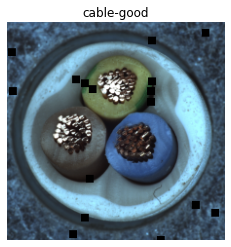

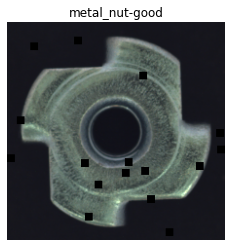

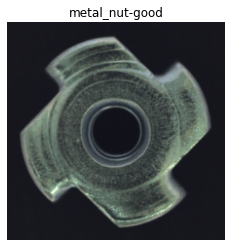

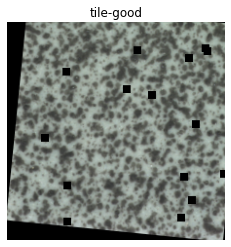

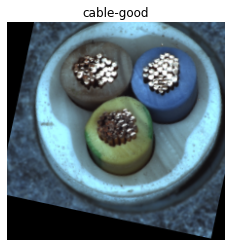

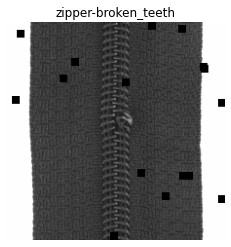

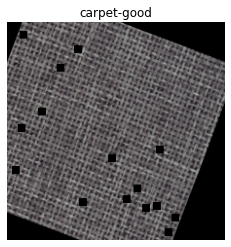

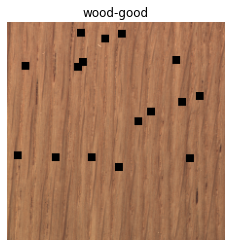

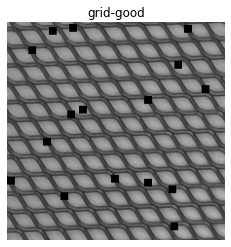

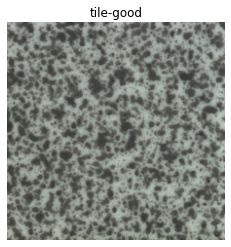

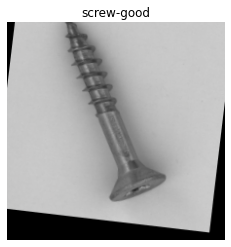

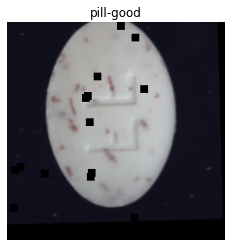

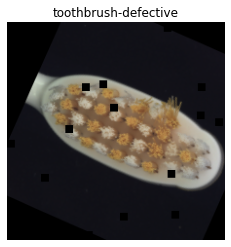

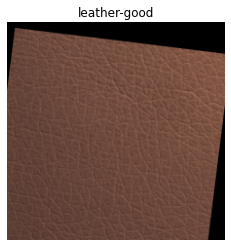

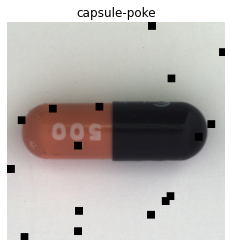

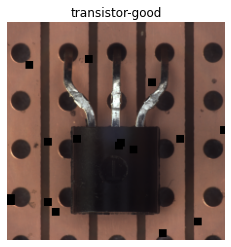

In [26]:
def visualize(input, title):
    # 이미지 정규화 해제하기
    input = input.moveaxis(0, -1)
    mean = np.array([0.4330, 0.4034, 0.3941])
    std = np.array([0.2602, 0.2572, 0.2535])
    input = input * std + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    fig = plt.figure()
    plt.axis("off")
    plt.imshow(input, rasterized=True)
    plt.title(title)
    plt.show()
    return fig
    
for batch in train_loader:
    images, labels = batch[0], batch[1]
    for image, label in zip(images, labels):
        fig = visualize(image, LABEL_DECODER[label.item()])
        neptune_run["preprocessed_image"].log(fig)
    break

# Model

In [27]:
class Network(nn.Module):
    def __init__(self, mode="train"):
        super(Network, self).__init__()
        self.mode = mode
        if self.mode == "train":
            self.drop_out_rate = params["drop_out_rate"]
            self.drop_path_rate = params["drop_path_rate"]
        elif self.mode == "test":
            self.drop_out_rate = 0
            self.drop_path_rate = 0
            
        self.backbone = timm.create_model(params["model_name"],
                                          pretrained=True,
                                          num_classes=params["num_class"],
                                          drop_rate=self.drop_out_rate,)
                                          # drop_path_rate=self.drop_path_rate)
        # self.linears = nn.ModuleList([NormedLinear(2432, NUM_CLASS) for _ in range(2)])
        # self.base_expert = nn.Linear(self.backbone.conv_head.out_channels, NUM_CLASS)
        # self.balance_expert = nn.Linear(self.backbone.conv_head.out_channels, NUM_CLASS)
        # self.inverse_expert = nn.Linear(self.backbone.conv_head.out_channels, NUM_CLASS)
        # self.RSG = RSG(n_center = 15, feature_maps_shape = [32, 16, 16], num_classes=num_classes, contrastive_module_dim = 256, head_class_lists = self.head_lists, transfer_strength = transfer_strength, epoch_thresh = epoch_thresh)
        # self.ml_decoder = MLDecoder(NUM_CLASS, initial_num_features=self.backbone.conv_head.out_channels)
        # self.classifier = nn.Linear(self.backbone.conv_head.out_channels, NUM_CLASS)
        # self.backbone.global_pool = nn.Identity()
        # del self.backbone.head
        # self.backbone.head = MLDecoder(NUM_CLASS, initial_num_features=self.backbone.norm.normalized_shape[0])


        
    def forward(self, x):
        if self.mode == "train":
            x = self.backbone(x)
            # feats = F.avg_pool2d(x, x.size()[3])
            # x = self.ml_decoder(x)
            # # feats = feats.view(feats.size(0), -1)
            return x#, torch.sum(torch.abs(feats), 1).reshape(-1, 1)
            # out1 = out.view(out.size(0), -1)
            # x = self.ml_decoder(x)
            # return {
            #     "base": self.linears[0](x),
            #     # "balance": self.linears[1](x),
            #     "inverse": self.linears[1](x)
            # }
        
        elif self.mode == "test":
            x = self.backbone(x)
            # x = self.ml_decoder(x)
            return x
            # outputs = []
            # for i in range(2):
            #     outputs.append(self.linears[i](x))
            # outs = []
            # for o in outputs:
            #     outs.append(o)
            # outputs = torch.stack(outs, dim=1).mean(dim=1)
            # return outputs
        
     
        
# class NormedLinear(nn.Module):

#     def __init__(self, in_features, out_features):
#         super(NormedLinear, self).__init__()
#         self.weight = Parameter(torch.Tensor(in_features, out_features))
#         self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

#     def forward(self, x):
#         out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
#         return out
    

class NormedLinear(nn.Linear):
    """Normalized Linear Layer.
    Args:
        tempeature (float, optional): Tempeature term. Default to 20.
        power (int, optional): Power term. Default to 1.0.
        eps (float, optional): The minimal value of divisor to
             keep numerical stability. Default to 1e-6.
    """

    def __init__(self, *args, tempearture=20, power=1.0, eps=1e-6, **kwargs):
        super(NormedLinear, self).__init__(*args, **kwargs)
        self.tempearture = tempearture
        self.power = power
        self.eps = eps
        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.weight, mean=0, std=0.01)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, x):
        weight_ = self.weight / (
            self.weight.norm(dim=1, keepdim=True).pow(self.power) + self.eps)
        x_ = x / (x.norm(dim=1, keepdim=True).pow(self.power) + self.eps)
        x_ = x_ * self.tempearture

        return F.linear(x_, weight_, self.bias)
    
    
# model = Network()
# # print(model(torch.randn(1, 3, 224, 224)))
# print(model)
# model.to(DEVICE)
# print(f"model {MODEL_NAME} create!")

# model
# from pprint import pprint
# model_names = timm.list_models("*tres*", pretrained=False)
# pprint(model_names)
# z

## Dyhead

In [28]:
# # # from pprint import pprint
# # # model_names = timm.list_models("*swin*", pretrained=True)
# # # pprint(model_names)
# from collections import OrderedDict

# class Network(nn.Module):
#     def __init__(self, mode="train"):
#         super(Network, self).__init__()
#         out_featrues = 256
#         self.mode = mode
#         # self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASS, drop_path_rate=DROP_PATH_RATIO)#num_classes=0, global_pool="")#, drop_path_rate=0.2)
#         self.backbone = timm.create_model(MODEL_NAME, pretrained=True, features_only=True, drop_path_rate=DROP_PATH_RATIO)
#         self.fpn = FeaturePyramidNetwork([48, 64, 160, 256], out_featrues)
#         self.concat_fpn = concat_feature_maps()
#         # self.scale_layer = Scale_Aware_Layer
#         # self.spatial_layer = Spatial_Aware_Layer
#         # self.task_layer = Task_Aware_Layer
#         # L: 4 S: 441 C: 256
#         self.dyhead = DyHead(num_blocks=6, L=4, S=784, C=256)
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.classifier = nn.Linear(256, NUM_CLASS)
#         # self.ml_decoder = MLDecoder(NUM_CLASS, initial_num_features=1280)
#         # for _, param in self.backbone.named_parameters():
#         #     param.requires_grad = False

#     def forward(self, x):
#         x = self.backbone(x)[1:]

#         x_dic = OrderedDict()
#         for i in range(len(x)):
#             x_dic[f"feat{i}"] = x[i]

#         x = self.fpn(x_dic)
#         x = self.concat_fpn(x)
#         x = self.dyhead(x)
        
#         F_tensor = x.permute(0, 3, 1, 2)
#         kernel_size = F_tensor.shape[2:] # Getting HxW of F
#         gap_output = F.avg_pool2d(F_tensor, kernel_size)

#         # Flattening gap_output from (batch_size, C, 1, 1) to (batch_size, C)
#         gap_output = gap_output.flatten(start_dim=1)
        
#         # x = x.transpose(dim0=1, dim1=-1)
#         # x = self.avg_pool(x)
#         # x = x.flatten(1)
#         x = self.classifier(gap_output)
#         return x
#         # feats = []
#         # for k, v in x.items():
#         #     v = self.avg_pool(v)
#         #     feats.append(v.flatten(1))
#         # feats = torch.cat(feats, 1)
        
#         # x = self.classifier(x)
#         # feats = self.backbone(x)
#         # x = self.classifier(feats)
#         # x = self.ml_decoder(x)
#         # return x
#         # if self.mode == "train":
#         #     return x, torch.sum(torch.abs(feats), 1).reshape(-1, 1)
#         # else:

        
# class concat_feature_maps(nn.Module):
#     def __init__(self):
#         super(concat_feature_maps, self).__init__()

#     def forward(self, fpn_output):
#         # Calculating median height to upsample or desample each fpn levels
#         heights = []
#         level_tensors = []
#         for key, values in fpn_output.items():
#             heights.append(values.shape[2])
#             level_tensors.append(values)
#         median_height = int(np.median(heights))

#         # Upsample and Desampling tensors to median height and width
#         for i in range(len(level_tensors)):
#             level = level_tensors[i]
#             # If level height is greater than median, then downsample with interpolate
#             if level.shape[2] > median_height:
#                 level = F.interpolate(input=level, size=(median_height, median_height),mode='nearest')
#             # If level height is less than median, then upsample
#             else:
#                 level = F.interpolate(input=level, size=(median_height, median_height), mode='nearest')
#             level_tensors[i] = level
        
#         # Concating all levels with dimensions (batch_size, levels, C, H, W)
#         concat_levels = torch.stack(level_tensors, dim=1)

#         # Reshaping tensor from (batch_size, levels, C, H, W) to (batch_size, levels, HxW=S, C)
#         concat_levels = concat_levels.flatten(start_dim=3).transpose(dim0=2, dim1=3)
#         return concat_levels


# class Scale_Aware_Layer(nn.Module):
#     # Constructor
#     def __init__(self, s_size):
#         super(Scale_Aware_Layer, self).__init__()

#         # Average Pooling
#         self.avg_layer = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        
#         #1x1 Conv layer
#         self.conv = nn.Conv2d(in_channels=s_size, out_channels=1, kernel_size=1)

#         # Hard Sigmoid
#         self.hard_sigmoid = nn.Hardsigmoid()

#         # ReLU function
#         self.relu = nn.ReLU()

#     def forward(self, F):

#         # Transposing input from (batch_size, L, S, C) to (batch_size, S, L, C) so we can use convolutional layer over the level dimension L
#         x = F.transpose(dim0=2, dim1=1)

#         # Passing tensor through avg pool layer
#         x = self.avg_layer(x)

#         # Passing tensor through Conv layer
#         x = self.conv(x)
        
#         # Reshaping Tensor from (batch_size, 1, L, C) to (batch_size, L, 1, C) to then be multiplied to F
#         x = x.transpose(dim0=1, dim1=2)

#         # Passing conv output to relu
#         x = self.relu(x)

#         # Passing tensor to hard sigmoid function
#         pi_L = self.hard_sigmoid(x)

#         # pi_L: (batch_size, L, 1, C)
#         # F: (batch_size, L, S, C)
#         return pi_L * F

    
# class Spatial_Aware_Layer(nn.Module):
#     # Constructor
#     def __init__(self, L_size, kernel_height=3, kernel_width=3, padding=1, stride=1, dilation=1, groups=1):
#         super(Spatial_Aware_Layer, self).__init__()

#         self.in_channels = L_size
#         self.out_channels = L_size

#         self.kernel_size = (kernel_height, kernel_width)
#         self.padding = padding
#         self.stride = stride
#         self.dilation = dilation
#         self.K = kernel_height * kernel_width
#         self.groups = groups

#         # 3x3 Convolution with 3K out_channel output as described in Deform Conv2 paper
#         self.offset_and_mask_conv = nn.Conv2d(in_channels=self.in_channels,
#                                               out_channels=3*self.K, #3K depth
#                                               kernel_size=self.kernel_size,
#                                               stride=self.stride,
#                                               padding=self.padding,
#                                               dilation=dilation)
        
#         self.deform_conv = DeformConv2d(in_channels=self.in_channels,
#                                         out_channels=self.out_channels,
#                                         kernel_size=self.kernel_size,
#                                         stride=self.stride,
#                                         padding=self.padding,
#                                         dilation=self.dilation,
#                                         groups=self.groups)
#     def forward(self, F):
#         # Generating offesets and masks (or modulators) for convolution operation
#         offsets_and_masks = self.offset_and_mask_conv(F)

#         # Separating offsets and masks as described in Deform Conv v2 paper
#         offset = offsets_and_masks[:, :2*self.K, :, :] # First 2K channels 
#         mask = torch.sigmoid(offsets_and_masks[:, 2*self.K:, : , :]) # Last 1K channels and passing it through sigmoid

#         # Passing offsets, masks, and F into deform conv layer
#         spacial_output = self.deform_conv(F, offset, mask)
#         return spacial_output

    
# # DyReLUA technique from Dynamic ReLU paper
# class DyReLUA(nn.Module):
#     def __init__(self, channels, reduction=8, k=2, lambdas=None, init_values=None):
#         super(DyReLUA, self).__init__()

#         self.fc1 = nn.Linear(channels, channels // reduction)
#         self.fc2 = nn.Linear(channels//reduction, 2*k)
#         self.relu = nn.ReLU(inplace=True)
#         self.sigmoid = nn.Sigmoid()

#         # Defining lambdas in form of [La1, La2, Lb1, Lb2]
#         if lambdas is not None:
#             self.lambdas = lambdas
#         else:
#             # Default lambdas from DyReLU paper
#             self.lambdas = torch.cuda.HalfTensor([1.0, 1.0, 0.5, 0.5])

#         # Defining Initializing values in form of [alpha1, alpha2, Beta1, Beta2]
#         if lambdas is not None:
#             self.init_values = init_values
#         else:
#             # Default initializing values of DyReLU paper
#             self.init_values = torch.cuda.HalfTensor([1.0, 0.0, 0.0, 0.0])

#     def forward(self, F_tensor):

#         # Global Averaging F
#         kernel_size = F_tensor.shape[2:] # Getting HxW of F
#         gap_output = F.avg_pool2d(F_tensor, kernel_size)

#         # Flattening gap_output from (batch_size, C, 1, 1) to (batch_size, C)
#         gap_output = gap_output.flatten(start_dim=1)

#         # Passing Global Average output through Fully-Connected Layers
#         x = self.relu(self.fc1(gap_output))
#         x = self.fc2(x)
        
#         # Normalization between (-1, 1)
#         residuals = 2 * self.sigmoid(x) - 1

#         # Getting values of theta, and separating alphas and betas
#         theta = self.init_values + self.lambdas * residuals # Contains[alpha1(x), alpha2(x), Beta1(x), Beta2(x)]
#         alphas = theta[0, :2]
#         betas = theta[0, 2:]

#         # Performing maximum on both piecewise functions
#         output = torch.maximum((alphas[0] * F_tensor + betas[0]), (alphas[1] * F_tensor + betas[1]))

#         return output

    
# class Task_Aware_Layer(nn.Module):
#     # Defining constructor
#     def __init__(self, num_channels):
#         super(Task_Aware_Layer, self).__init__()

#         # DyReLUA relu
#         self.dynamic_relu = DyReLUA(num_channels)
    
#     def forward(self, F_tensor):
#         # Permutating F from (batch_size, L, S, C) to (batch_size, C, L, S) so we can reduce the dimensions over LxS
#         F_tensor = F_tensor.permute(0, 3, 1, 2)
#         output = self.dynamic_relu(F_tensor)
        
#         # Reversing the permutation
#         output = output.permute(0, 2, 3, 1)

#         return output


# class DyHead_Block(nn.Module):
#     def __init__(self, L, S, C):
#         super(DyHead_Block, self).__init__()
#         # Saving all dimension sizes of F
#         self.L_size = L
#         self.S_size = S
#         self.C_size = C

#         # Inititalizing all attention layers
#         self.scale_attention = Scale_Aware_Layer(s_size=self.S_size)
#         self.spatial_attention = Spatial_Aware_Layer(L_size=self.L_size)
#         self.task_attention = Task_Aware_Layer(num_channels=self.C_size)

#     def forward(self, F_tensor):
#         scale_output = self.scale_attention(F_tensor)
#         spacial_output = self.spatial_attention(scale_output)
#         task_output = self.task_attention(spacial_output)

#         return task_output

# def DyHead(num_blocks, L, S, C):
#     blocks = [('Block_{}'.format(i+1),DyHead_Block(L, S, C)) for i in range(num_blocks)]

#     return nn.Sequential(OrderedDict(blocks))


# model = Network()
# model.to(DEVICE)
# print(f"model {MODEL_NAME} create!")
# # for i, (k, param) in enumerate(model.named_parameters()):
# #     if i < 644:
# #         param.requires_grad = False
# #     print(i, k, param.requires_grad)

## ML-Decoder

In [29]:
def add_ml_decoder_head(model, num_classes=-1, num_of_groups=-1, decoder_embedding=768, zsl=0):
    if num_classes == -1:
        num_classes = model.num_classes
    num_features = model.num_features
    if hasattr(model, 'global_pool') and hasattr(model, 'fc'):  # resnet50
        model.global_pool = nn.Identity()
        del model.fc
        model.fc = MLDecoder(num_classes=num_classes, initial_num_features=num_features, num_of_groups=num_of_groups,
                             decoder_embedding=decoder_embedding, zsl=zsl)
    elif hasattr(model, 'head'):  # tresnet
        if hasattr(model, 'global_pool'):
            model.global_pool = nn.Identity()
        del model.head
        model.head = MLDecoder(num_classes=num_classes, initial_num_features=num_features, num_of_groups=num_of_groups,
                               decoder_embedding=decoder_embedding, zsl=zsl)
    else:
        print("model is not suited for ml-decoder")
        exit(-1)

    return model


class TransformerDecoderLayerOptimal(nn.Module):
    def __init__(self, d_model, nhead=8, dim_feedforward=2048, dropout=0.1, activation="relu",
                 layer_norm_eps=1e-5) -> None:
        super(TransformerDecoderLayerOptimal, self).__init__()
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = torch.nn.functional.relu
        super(TransformerDecoderLayerOptimal, self).__setstate__(state)

    def forward(self, tgt, memory, tgt_mask = None,
                memory_mask = None,
                tgt_key_padding_mask = None,
                memory_key_padding_mask = None):
        tgt = tgt + self.dropout1(tgt)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class GroupFC(object):
    def __init__(self, embed_len_decoder: int):
        self.embed_len_decoder = embed_len_decoder

    def __call__(self, h, duplicate_pooling, out_extrap):
        for i in range(h.shape[1]):
            h_i = h[:, i, :]
            if len(duplicate_pooling.shape)==3:
                w_i = duplicate_pooling[i, :, :]
            else:
                w_i = duplicate_pooling
            out_extrap[:, i, :] = torch.matmul(h_i, w_i)


class MLDecoder(nn.Module):
    def __init__(self, num_classes, num_of_groups=-1, decoder_embedding=768,
                 initial_num_features=2048, zsl=0):
        super(MLDecoder, self).__init__()
        embed_len_decoder = 100 if num_of_groups < 0 else num_of_groups
        if embed_len_decoder > num_classes:
            embed_len_decoder = num_classes

        # switching to 768 initial embeddings
        decoder_embedding = 768 if decoder_embedding < 0 else decoder_embedding
        embed_standart = nn.Linear(initial_num_features, decoder_embedding)

        # non-learnable queries
        if not zsl:
            query_embed = nn.Embedding(embed_len_decoder, decoder_embedding)
            query_embed.requires_grad_(False)
        else:
            query_embed = None

        # decoder
        decoder_dropout = 0.1
        num_layers_decoder = 1
        dim_feedforward = 2048
        layer_decode = TransformerDecoderLayerOptimal(d_model=decoder_embedding,
                                                      dim_feedforward=dim_feedforward, dropout=decoder_dropout)
        self.decoder = nn.TransformerDecoder(layer_decode, num_layers=num_layers_decoder)
        self.decoder.embed_standart = embed_standart
        self.decoder.query_embed = query_embed
        self.zsl = zsl

        if self.zsl:
            if decoder_embedding != 300:
                self.wordvec_proj = nn.Linear(300, decoder_embedding)
            else:
                self.wordvec_proj = nn.Identity()
            self.decoder.duplicate_pooling = torch.nn.Parameter(torch.Tensor(decoder_embedding, 1))
            self.decoder.duplicate_pooling_bias = torch.nn.Parameter(torch.Tensor(1))
            self.decoder.duplicate_factor = 1
        else:
            # group fully-connected
            self.decoder.num_classes = num_classes
            self.decoder.duplicate_factor = int(num_classes / embed_len_decoder + 0.999)
            self.decoder.duplicate_pooling = torch.nn.Parameter(
                torch.Tensor(embed_len_decoder, decoder_embedding, self.decoder.duplicate_factor))
            self.decoder.duplicate_pooling_bias = torch.nn.Parameter(torch.Tensor(num_classes))
        torch.nn.init.xavier_normal_(self.decoder.duplicate_pooling)
        torch.nn.init.constant_(self.decoder.duplicate_pooling_bias, 0)
        self.decoder.group_fc = GroupFC(embed_len_decoder)
        self.train_wordvecs = None
        self.test_wordvecs = None

    def forward(self, x):
        if len(x.shape) == 4:  # [bs,2048, 7,7]
            embedding_spatial = x.flatten(2).transpose(1, 2)
        else:  # [bs, 197,468]
            embedding_spatial = x
        embedding_spatial_786 = self.decoder.embed_standart(embedding_spatial)
        embedding_spatial_786 = torch.nn.functional.relu(embedding_spatial_786, inplace=True)

        bs = embedding_spatial_786.shape[0]
        if self.zsl:
            query_embed = torch.nn.functional.relu(self.wordvec_proj(self.decoder.query_embed))
        else:
            query_embed = self.decoder.query_embed.weight
        # tgt = query_embed.unsqueeze(1).repeat(1, bs, 1)
        tgt = query_embed.unsqueeze(1).expand(-1, bs, -1)  # no allocation of memory with expand
        h = self.decoder(tgt, embedding_spatial_786.transpose(0, 1))  # [embed_len_decoder, batch, 768]
        h = h.transpose(0, 1)

        out_extrap = torch.zeros(h.shape[0], h.shape[1], self.decoder.duplicate_factor, device=h.device, dtype=h.dtype)
        self.decoder.group_fc(h, self.decoder.duplicate_pooling, out_extrap)
        if not self.zsl:
            h_out = out_extrap.flatten(1)[:, :self.decoder.num_classes]
        else:
            h_out = out_extrap.flatten(1)
        h_out += self.decoder.duplicate_pooling_bias
        logits = h_out
        return logits

# Optimizer & Criterion & Scheduler

In [30]:
model = Network()
model.to(DEVICE)

# for i, (k, param) in enumerate(model.named_parameters()):
#     if i < 363:
#         param.requires_grad = False
#     print(i, k, param.requires_grad)

if "sam" in params["optimizer"]:
    if "adam" in params["optimizer"]:
        base_optimizer = torch.optim.AdamW
    elif "sgd" in params["optimizer"]:
        base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=params["learning_rate"], rho=2.0, adaptive=True, weight_decay=params["weight_decay"])
    if "cosineannealinglr" in params["scheduler"]:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.base_optimizer, T_max=params["epochs"], verbose=True)
    elif "cosineannealingwarmuprestarts" in params["scheduler"]:
        scheduler = CosineAnnealingWarmUpRestarts(optimizer.base_optimizer, T_0=50, T_mult=1, eta_max=params["learning_rate"],  T_up=0, gamma=0.5)
else:
    if "adam" in params["optimizer"]:
        optimizer = torch.optim.AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
    elif "sgd" in params["optimizer"]:
        optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"], momentum=0.9)
    if "cosineannealinglr" in params["scheduler"]:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["epochs"], verbose=True)
    elif "cosineannealingwarmuprestarts" in params["scheduler"]:
        scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=params["learning_rate"],  T_up=0, gamma=0.5)

if "ib" in params["criterion"]:
    per_cls_weights = 1.0 / np.array(SAMPLES_PER_CLS)
    per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(SAMPLES_PER_CLS)
    per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    criterion_ib = IB_FocalLoss(weight=per_cls_weights, alpha=1000, gamma=1).cuda()
    # criterion_ib = IBLoss(weight=per_cls_weights, alpha=1000).cuda()
elif "ce" in params["criterion"]:
    criterion = nn.CrossEntropyLoss().cuda()
elif "sc" in params["criterion"]:
    criterion = SmoothCrossentropy().cuda()
elif "de" in params["criterion"]:
    criterion = DiverseExpertLoss(SAMPLES_PER_CLS).cuda()
elif "bs" in params["criterion"]:
    criterion = BalancedSoftmax().cuda()
    
scaler = torch.cuda.amp.GradScaler()
print(f"model {params['model_name']} create!")

Adjusting learning rate of group 0 to 1.0000e-04.
model tf_efficientnet_b0 create!


# Train

## train

In [31]:
def train(model, optimizer, data_loader, epochs, criterion=None):
    best_f1_score = 0
    for epoch in range(epochs):
        train_log = ""
        start=time.time()
        train_pred = []
        train_y = []
        train_f1_score = 0
        batch_time = AverageMeter("Time", ":.0f")
        losses = AverageMeter("Loss", ":.4e")
        correct = AverageMeter("Acc", ":.5f")

        model.train()
        for batch in tqdm(data_loader):                              
            inputs = batch[0].cuda(non_blocking=True)
            targets = batch[1].cuda(non_blocking=True)

            if params["mixup"] and epoch < params["mixup_end_epoch"]:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, MIXUP_ALPHA)

            if "sam" in params["optimizer"]:
                # first forward-backward step
                enable_running_stats(model)
                with torch.cuda.amp.autocast():
                    if "ib" in params["criterion"]:
                        outputs, features = model(inputs)
                    else:
                        outputs = model(inputs)
                    if params["mixup"] and epoch < params["mixup_end_epoch"]:
                        if "ib" in params["criterion"] and epoch > params["ib_start_epoch"]:
                            loss = mixup_criterion("ib", (outputs, features), targets_a, targets_b, lam)
                        else:
                            loss = mixup_criterion("cr", outputs, targets_a, targets_b, lam)
                    else:
                        if "ib" in params["criterion"] and epoch > params["ib_start_epoch"]:
                            loss = criterion_ib((outputs, features), targets)
                        else:
                            loss = criterion(outputs, targets)
                loss.backward()
                optimizer.first_step(zero_grad=True)

                # second forward-backward step
                disable_running_stats(model)
                with torch.cuda.amp.autocast():
                    if params["mixup"] and epoch < params["mixup_end_epoch"]:
                        if "ib" in params["criterion"]:
                            if epoch > params["ib_start_epoch"]:
                                second_loss = mixup_criterion("ib", model(inputs), targets_a, targets_b, lam)
                            else:
                                second_loss = mixup_criterion("cr", model(inputs)[0], targets_a, targets_b, lam)
                        else:
                            second_loss = mixup_criterion("cr", model(inputs), targets_a, targets_b, lam)
                    else:
                        if "ib" in params["criterion"]:
                            if epoch > params["ib_start_epoch"]:
                                second_loss = criterion_ib(model(inputs), targets)
                            else:
                                second_loss = criterion(model(inputs)[0], targets)
                        else:
                            second_loss = criterion(model(inputs), targets)
                second_loss.backward()
                optimizer.second_step(zero_grad=True)
                              
            else:
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    if "ib" in params["criterion"]:
                        outputs, features = model(inputs)
                    else:
                        outputs = model(inputs)
                    if params["mixup"] and epoch < params["mixup_end_epoch"]:
                        if "ib" in params["criterion"] and epoch > params["ib_start_epoch"]:
                            loss = mixup_criterion("ib", (outputs, features), targets_a, targets_b, lam)
                        else:
                            loss = mixup_criterion("cr", outputs, targets_a, targets_b, lam)
                    else:
                        if "ib" in params["criterion"] and epoch > params["ib_start_epoch"]:
                            loss = criterion_ib((outputs, features), targets)
                        else:
                            loss = criterion(outputs, targets)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                scaler.step(optimizer)
                scaler.update()
                
            losses.update(loss.item(), inputs.size(0))
            if epoch < params["mixup_end_epoch"]:
                _, pred = torch.max(outputs.data, 1)
                mixup_correct = (lam * pred.eq(targets_a.data).cpu().sum().float()
                            + (1 - lam) * pred.eq(targets_b.data).cpu().sum().float())
                
                correct.update(mixup_correct, inputs.size(0))
            else:
                train_pred += outputs.argmax(1).detach().cpu().numpy().tolist()
                train_y += targets.detach().cpu().numpy().tolist()

        if epoch >= params["mixup_end_epoch"]:
            train_f1_score = score_function(train_y, train_pred)

        if "ib" in params["criterion"] and epoch >= params["ib_start_epoch"]:
            adjust_learning_rate(optimizer.base_optimizer, epoch)
        else:
            scheduler.step()

        if best_f1_score <= train_f1_score:
            best_f1_score = train_f1_score
            torch.save(model.state_dict(), params["model_name"]+"_best.pt")
            train_log += "best model saved!"
            if best_f1_score == 1:
                train_log += "f1 score is 1!!"
                break

        torch.save(model.state_dict(), params["model_name"]+"_last.pt")
        train_log += "last model saved!"

        batch_time.update(time.time() - start)
        train_log += f"epoch : {epoch+1}/{epochs}    time : {batch_time.val:.0f}s/{batch_time.val*(epochs-epoch-1):.0f}s\n"
        if epoch < params["mixup_end_epoch"]:
            train_log += f"TRAIN    loss : {losses.avg:.5f}    accuracy : {correct.avg:.5f}\n"
        else:
            train_log += f"TRAIN    loss : {losses.avg:.5f}    f1 : {train_f1_score:.5f}\n"
        logger.info(train_log)

## Start Train

In [ ]:
train(model=model, optimizer=optimizer, data_loader=train_loader, epochs=params["epochs"], criterion=criterion)

  0%|          | 0/268 [00:00<?, ?it/s]

[2022-05-15 00:11:12]
best model saved!last model saved!epoch : 1/100    time : 25s/2428s
TRAIN    loss : 1.51459    f1 : 0.14636



Adjusting learning rate of group 0 to 9.9975e-05.


  0%|          | 0/268 [00:00<?, ?it/s]

[2022-05-15 00:11:33]
best model saved!last model saved!epoch : 2/100    time : 21s/2087s
TRAIN    loss : 0.83634    f1 : 0.19620



Adjusting learning rate of group 0 to 9.9901e-05.


  0%|          | 0/268 [00:00<?, ?it/s]

[2022-05-15 00:11:54]
best model saved!last model saved!epoch : 3/100    time : 21s/2067s
TRAIN    loss : 0.67229    f1 : 0.25342



Adjusting learning rate of group 0 to 9.9778e-05.


  0%|          | 0/268 [00:00<?, ?it/s]

[2022-05-15 00:12:16]
best model saved!last model saved!epoch : 4/100    time : 21s/2053s
TRAIN    loss : 0.56689    f1 : 0.34522



Adjusting learning rate of group 0 to 9.9606e-05.


  0%|          | 0/268 [00:00<?, ?it/s]

In [ ]:
# z

# Test

## Test data

In [ ]:
test_df = pd.read_csv(TEST_FILE)
test_dataset = CustomDataset(df=test_df, mode="test")
test_loader = DataLoader(
                    test_dataset,
                    batch_size=BATCH,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)

## TTA

In [ ]:
torch.cuda.empty_cache()

tta_transform = tta.Compose(
    [
        # tta.HorizontalFlip(),
        # tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 90, 180, 270]),
        # tta.Scale(scales=[0.6, 0.8, 1]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

## Test predict

In [ ]:
model = Network(mode="test")
model.load_state_dict(torch.load(MODEL_WEIGHT_NAME+"_best.pt"))
# model.load_state_dict(torch.load("tf_efficientnetv2_m_in21ft1k_120epochs_16batchsize_300imagesize_384testimagesize_0.0001lr_last.pt"))
model.to(DEVICE)
print("Load "+MODEL_WEIGHT_NAME)
tta_model = tta.ClassificationTTAWrapper(model, tta_transform)

model.eval()
f_pred = []

print("test image size:", TEST_IMAGE_SIZE)

with torch.no_grad():
    for batch in tqdm(test_loader):
        x = batch.cuda()
        with torch.cuda.amp.autocast():
            # outputs = tta_model(x)
            outputs = model(x)
        f_pred.extend(outputs.argmax(1).detach().cpu().numpy().tolist())

# Test labeling
f_result = [LABEL_DECODER[result] for result in f_pred]

# Submission
submission = pd.read_csv("data/sample_submission.csv")
submission["label"] = f_result
submission.to_csv(SAVE_FILE_NAME, index = False)

neptune_run.stop()